Data Source:

[Flight Data](https://www.kaggle.com/datasets/polartech/flight-data-with-1-million-or-more-records)

In [3]:
import os
import time
import random
import pandas as pd
from datetime import datetime

import statistics
import networkx as nx
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("../data/flight_data.csv")

In [5]:
df.departure_time = pd.to_datetime(df.departure_time)
df.arrival_time = pd.to_datetime(df.arrival_time)

In [6]:
df.head(5)

,from_airport_code,from_country,dest_airport_code,dest_country,aircraft_type,airline_number,airline_name,flight_number,departure_time,arrival_time,duration,stops,price,currency,co2_emissions,avg_co2_emission_for_this_route,co2_percentage,scan_date
0,ALG,Algeria,AEP,Argentina,Airbus A318|Canadair RJ 1000|Airbus A330|Airbu...,multi,[Air France| Iberia| LATAM],AF1491|AF1491|AF1491|AF1491,2022-04-30 14:30:00,2022-05-01 10:15:00,1425,3,1279.0,USD,1320000.0,1320000.0,0%,2022-04-29 17:52:59
1,ALG,Algeria,AEP,Argentina,Airbus A318|Canadair RJ 1000|Boeing 787|Airbus...,multi,[Air France| Iberia| LATAM],AF1491|AF1491|AF1491|AF1491,2022-04-30 14:30:00,2022-05-01 10:15:00,1425,3,1279.0,USD,1195000.0,1320000.0,-9%,2022-04-29 17:52:59
2,ALG,Algeria,AEP,Argentina,Airbus A320|Airbus A321|Boeing 787|Airbus A320,multi,[Air France| LATAM],AF1855|AF1855|AF1855|AF1855,2022-04-30 12:45:00,2022-05-01 10:15:00,1530,3,1284.0,USD,1248000.0,1320000.0,-5%,2022-04-29 17:52:59
3,ALG,Algeria,AEP,Argentina,Airbus A318|Airbus A320|Boeing 787|Airbus A320,multi,[Air France| LATAM],AF1491|AF1491|AF1491|AF1491,2022-04-30 14:30:00,2022-05-01 10:15:00,1425,3,1290.0,USD,1347000.0,1320000.0,2%,2022-04-29 17:52:59
4,ALG,Algeria,AEP,Argentina,Airbus A321neo|Boeing 777|Airbus A320,multi,[Lufthansa| LATAM],LH1317|LH1317|LH1317,2022-04-30 12:35:00,2022-05-01 10:15:00,1540,2,1347.0,USD,1381000.0,1320000.0,4%,2022-04-29 17:52:59


In [7]:
((df.arrival_time - df.departure_time).dt.total_seconds() / 60 / 60).describe()

count    998866.000000
mean         23.096047
std          12.803078
min          -3.500000
25%          13.416667
50%          21.283333
75%          30.166667
max         114.583333
dtype: float64

In [8]:
(df.duration / 60).describe()

count    998866.000000
mean         24.470229
std          11.763328
min           0.916667
25%          16.216667
50%          23.500000
75%          31.333333
max         101.583333
Name: duration, dtype: float64

In [9]:
df.from_country.value_counts()

from_country
China        125384
Germany      108820
Australia     91727
Brazil        75979
India         62566
Canada        55056
Denmark       53745
France        52340
Belgium       48776
Dublin        48634
Austria       48284
Greece        48084
Columbia      43324
Egypt         42330
Chile         37025
Argentina     21483
Ethiopia      19572
Algeria       15737
Name: count, dtype: int64

# Network Analysis

In [10]:
df.dest_country.value_counts().keys() # geocode this?

Index(['United States', 'United Kingdom', 'India', 'Germany', 'Brazil',
       'Australia', 'China', 'Japan', 'South Africa', 'Canada', 'Italy',
       'Rome', 'Mexico', 'Zurich', 'France', 'Spain', 'Portugal', 'Belgium',
       'Denmark', 'Netherlands', 'Austria', 'Dublin', 'Sweden', 'Thailand',
       'Turkey', 'Norway', 'Singapore', 'Greece', 'Columbia', 'Egypt', 'Peru',
       'South Korea', 'United Arab Emirates', 'Argentina', 'Qatar', 'Malaysia',
       'Panama', 'Philippines', 'Chile', 'Kenya', 'Indonesia', 'Vietnam',
       'Taiwan', 'Russia', 'Algeria', 'Morocco', 'Ethiopia'],
      dtype='object', name='dest_country')

In [11]:
df_sample = df.sample(10_000, random_state=311223)

G = nx.DiGraph()

for index, row in df_sample.iterrows():
    G.add_edge(
        row['from_airport_code'], 
        row['dest_airport_code'], 
        departure_time=row['departure_time'],
        arrival_time=row['arrival_time'],
        duration=row['duration'],
        price=row['price']
    )


num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

num_nodes, num_edges


(78, 1838)

In [12]:
# plt.figure(figsize=(12, 8))
# nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
# plt.title("Flight Network Graph")
# plt.show()

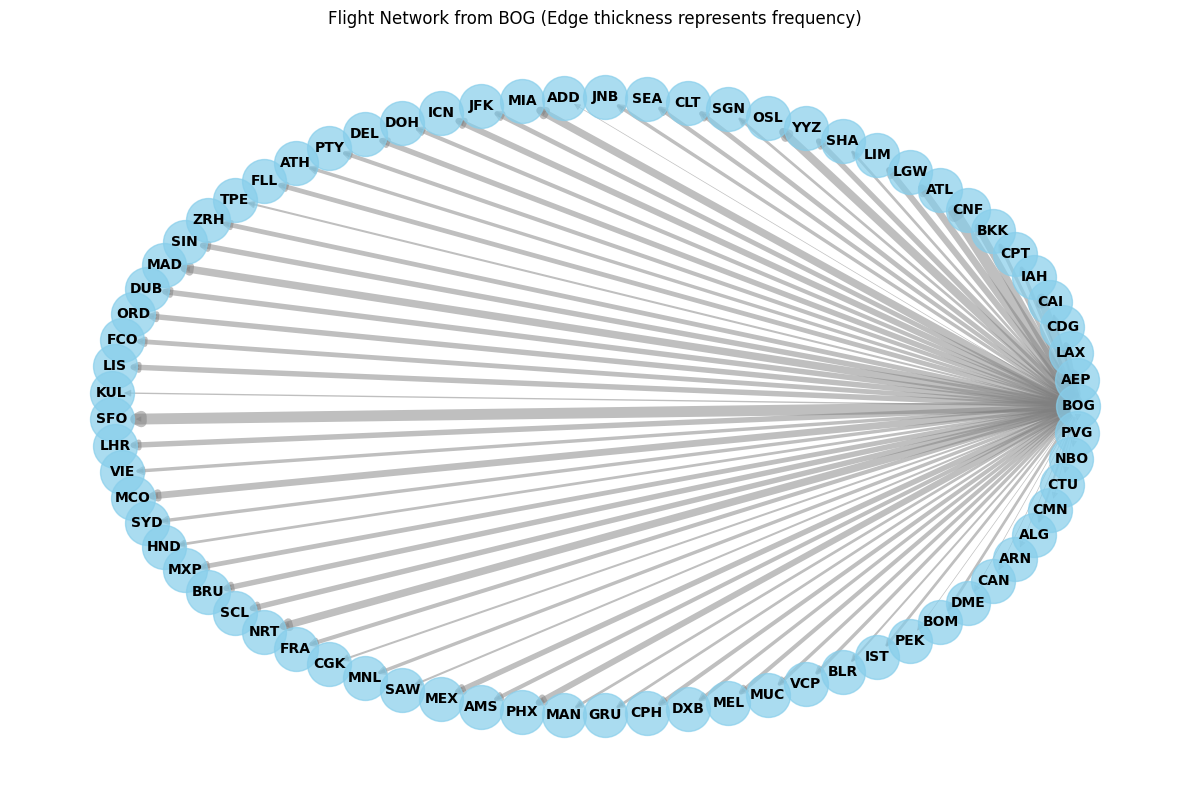

In [13]:
# filter to the desired origin
bog_flights = df_sample[df_sample['from_airport_code'] == 'BOG']

G_bog = nx.DiGraph()

# add edges to the graph, with the thickness representing the frequency of flights
# we will use a defaultdict to count the frequency of flights between each pair of airports
from collections import defaultdict
flight_frequency = defaultdict(int)

for _, row in bog_flights.iterrows():
    flight_frequency[(row['from_airport_code'], row['dest_airport_code'])] += 1

# add edges with frequency as the weight
for (origin, destination), frequency in flight_frequency.items():
    G_bog.add_edge(origin, destination, weight=frequency)

# pos = nx.spring_layout(G_bog)
pos = nx.circular_layout(G_bog)  # nodes in circle

plt.figure(figsize=(12, 8))

nx.draw_networkx_nodes(G_bog, pos, node_size=1000, node_color='skyblue', alpha=0.7)
nx.draw_networkx_labels(G_bog, pos, font_size=10, font_weight='bold')

# draw the edges, with thickness representing the frequency
weights_mean = statistics.mean(flight_frequency.values())
edge_width = [G_bog[u][v]['weight'] / weights_mean * 3 for u, v in G_bog.edges()]
nx.draw_networkx_edges(G_bog, pos, width=edge_width, edge_color='grey', alpha=0.5)

# highlight the optimized routes with color
# nx.draw_networkx_edges(G_bog, pos, edgelist=optimized_edges, edge_color='red', width=2, alpha=0.7)

plt.title('Flight Network from BOG (Edge thickness represents frequency)')
plt.axis('off')
plt.tight_layout()
plt.savefig("../outputs/frequent_flights.png", dpi=320)

plt.show()


for more implementations:

[NetworkX Shortest Path Algorithms](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.shortest_path.html#networkx.algorithms.shortest_paths.generic.shortest_path)

In [14]:
# custom function to optimize the network
def optimize_flight_schedule(graph):
    # finding most profitable paths. The weight can be any variable in the dataset!
    path_weights = nx.all_pairs_dijkstra_path_length(graph, weight='price')
    
    final_sorted_paths = {}
    for source, weights in path_weights:
        # filter out the self-path (going back to the origin) and paths with non-positive weights
        filtered_weights = {node: weight for node, weight in weights.items() if node != source and weight > 0}
        
        # if not filtered_weights: final_sorted_paths[source] = []
        if not filtered_weights: continue # skip empty paths
            
        # sort the paths as desired (since Djikstra's finds the min path)
        sorted_paths = sorted(filtered_weights.items(), key=lambda x: x[1], reverse=True) # is this valid?
        final_sorted_paths[source] = sorted_paths
        
    return final_sorted_paths

# run the optimization algorithm
optimized_paths = optimize_flight_schedule(G)

# optimized_paths.get("BOG")

In [15]:
optimized_paths.get("BOG")[:10] # top 10 highest priced flights

[('CGO', 3274.0),
 ('PEK', 3246.0),
 ('CTU', 3048.0),
 ('SHA', 2956.0),
 ('SZX', 2952.0),
 ('HGH', 2896.0),
 ('XIY', 2806.0),
 ('CAN', 2638.0),
 ('PVG', 2320.0),
 ('HND', 2121.0)]

So when the origin is Bogotá, Colombia. Airlines should prioritize flights to Asia to maximize profits.

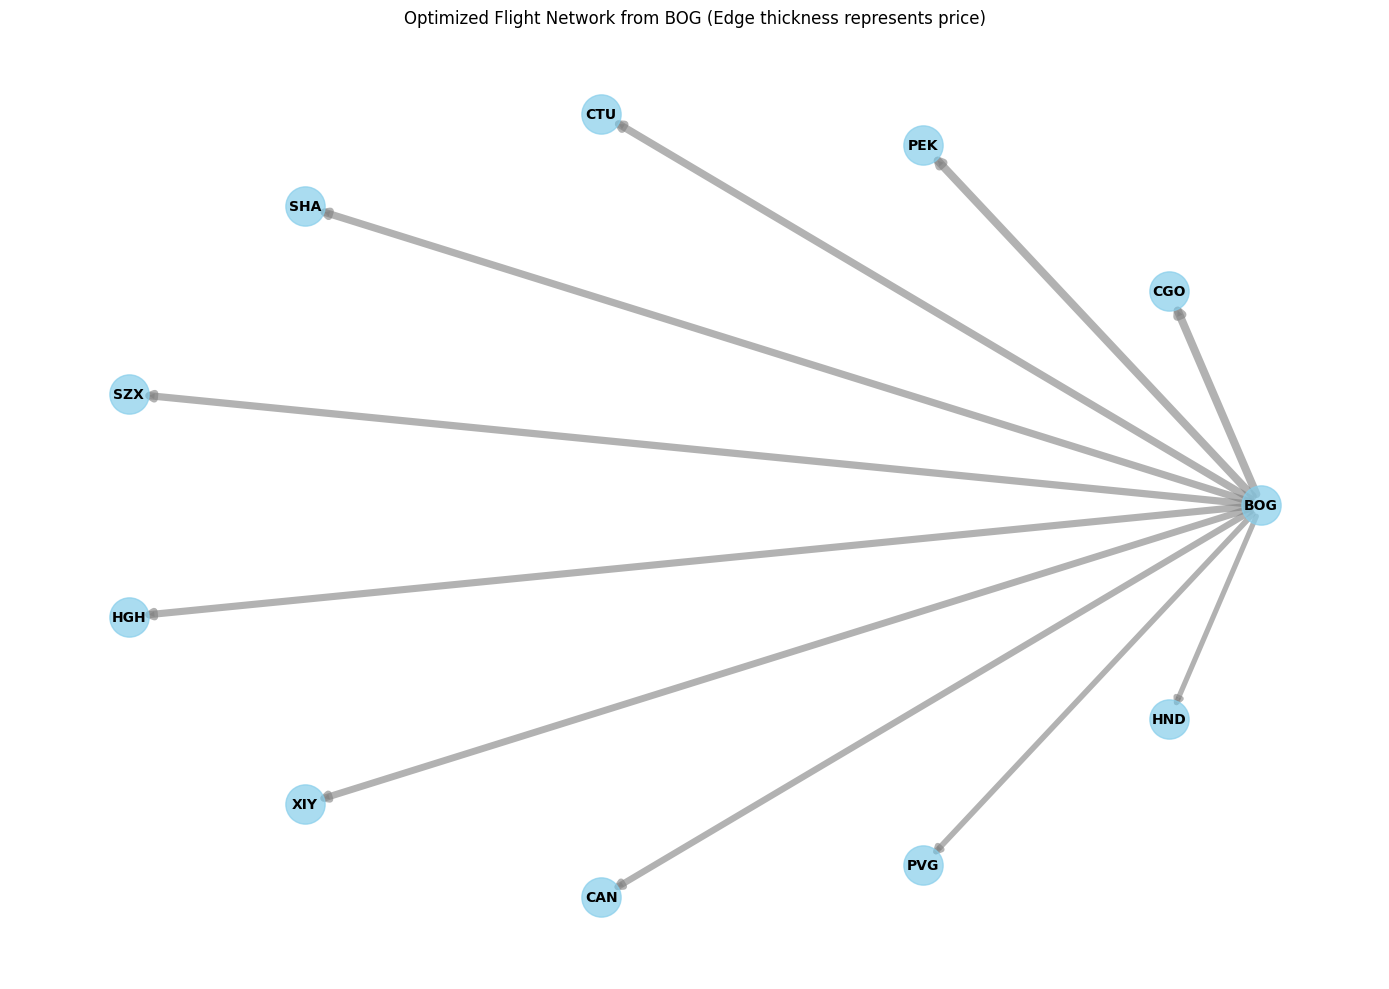

In [16]:
G_bog_optimized = nx.DiGraph()

bog_optimized = optimized_paths.get("BOG")[:10]

# add edges to the graph, using the price as the weight
for destination, price in bog_optimized:
    G_bog_optimized.add_edge('BOG', destination, weight=price)

# Now create the visualization
plt.figure(figsize=(14, 10))

# pos = nx.spring_layout(G_bog_optimized, seed=311223)
pos = nx.circular_layout(G_bog_optimized)

nx.draw_networkx_nodes(G_bog_optimized, pos, node_size=800, node_color='skyblue', alpha=0.7)
nx.draw_networkx_labels(G_bog_optimized, pos, font_size=10, font_weight='bold')

# now the width should be based on price
weights_mean = statistics.mean(dict(bog_optimized).values()) # to not make the scaling random?
edge_widths = [G_bog_optimized[u][v]['weight'] / weights_mean * 5 for u, v in G_bog_optimized.edges()]  # scale down the price for width

nx.draw_networkx_edges(G_bog_optimized, pos, width=edge_widths, edge_color='grey', alpha=0.6)

plt.title('Optimized Flight Network from BOG (Edge thickness represents price)')
plt.axis('off')
plt.tight_layout()

plt.show()